In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 2.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=1647a16f4a5fd317156109b2da5d53b86fd57cee2fc25918729bf12adf7216ab
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
! mkdir ~/.kaggle/
! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c deepfake-detection-challenge

100% 4.13G/4.13G [01:39<00:00, 64.6MB/s]
100% 4.13G/4.13G [01:39<00:00, 44.5MB/s]


In [ ]:
!unzip /content/deepfake-detection-challenge.zip -d /content/

Archive:  /content/deepfake-detection-challenge.zip
  inflating: /content/sample_submission.csv  
  inflating: /content/test_videos/aassnaulhq.mp4  
  inflating: /content/test_videos/aayfryxljh.mp4  
  inflating: /content/test_videos/acazlolrpz.mp4  
  inflating: /content/test_videos/adohdulfwb.mp4  
  inflating: /content/test_videos/ahjnxtiamx.mp4  
  inflating: /content/test_videos/ajiyrjfyzp.mp4  
  inflating: /content/test_videos/aktnlyqpah.mp4  
  inflating: /content/test_videos/alrtntfxtd.mp4  
  inflating: /content/test_videos/aomqqjipcp.mp4  
  inflating: /content/test_videos/apedduehoy.mp4  
  inflating: /content/test_videos/apvzjkvnwn.mp4  
  inflating: /content/test_videos/aqrsylrzgi.mp4  
  inflating: /content/test_videos/axfhbpkdlc.mp4  
  inflating: /content/test_videos/ayipraspbn.mp4  
  inflating: /content/test_videos/bcbqxhziqz.mp4  
  inflating: /content/test_videos/bcvheslzrq.mp4  
  inflating: /content/test_videos/bdshuoldwx.mp4  
  inflating: /content/test_videos/b

In [ ]:
import dlib
import cv2
import os
import re
import json
from pylab import *
from PIL import Image, ImageChops, ImageEnhance

In [ ]:
#extract faces
from tqdm import tqdm

predictor_path = "shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(predictor_path)
train_frame_folder = 'train_sample_videos'
with open(os.path.join(train_frame_folder, 'metadata.json'), 'r') as file:
    data = json.load(file)
list_of_train_data = [f for f in os.listdir(train_frame_folder) if f.endswith('.mp4')]
detector = dlib.get_frontal_face_detector()
for vid in tqdm(list_of_train_data):
    count = 0
    cap = cv2.VideoCapture(os.path.join(train_frame_folder, vid))
    frameRate = cap.get(5)
    while cap.isOpened():
        frameId = cap.get(1)
        ret, frame = cap.read()
        if ret != True:
            break
        if frameId % ((int(frameRate)+1)*1) == 0:
            face_rects, scores, idx = detector.run(frame, 0)
            for i, d in enumerate(face_rects):
                shape = predictor(frame, d)
                pad = 10
                # The next lines of code just get the coordinates for the mouth
                # and crop the mouth from the image.This part can probably be optimised
                # by taking only the outer most points.
                xmouthpoints = [shape.part(x).x for x in range(48,67)]
                ymouthpoints = [shape.part(x).y for x in range(48,67)]
                maxx = max(xmouthpoints)
                minx = min(xmouthpoints)
                maxy = max(ymouthpoints)
                miny = min(ymouthpoints) 
                crop_img = frame[miny-pad:maxy+pad,minx-pad:maxx+pad]
                # x1 = d.left()
                # y1 = d.top()
                # x2 = d.right()
                # y2 = d.bottom()
                # crop_img = frame[y1:y2, x1:x2]
                if data[vid]['label'] == 'REAL':
                    cv2.imwrite('/content/drive/MyDrive/real/'+vid.split('.')[0]+'_'+str(count)+'.png', cv2.resize(crop_img, (128, 128)))
                elif data[vid]['label'] == 'FAKE':
                    cv2.imwrite('/content/drive/MyDrive/fake/'+vid.split('.')[0]+'_'+str(count)+'.png', cv2.resize(crop_img, (128, 128)))
                count+=1

100%|██████████| 400/400 [49:05<00:00,  7.36s/it]


In [ ]:
# training
import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
from tqdm import tqdm
input_shape = (128, 128, 3)
data_dir = '/content/drive/MyDrive/'

real_data = [f for f in os.listdir(data_dir+'/real') if f.endswith('.png')]
fake_data = [f for f in os.listdir(data_dir+'/fake') if f.endswith('.png')]

X = []
Y = []

for img in tqdm(real_data):
    X.append(img_to_array(load_img(data_dir+'/real/'+img)).flatten() / 255.0)
    Y.append(1)
for img in tqdm(fake_data):
    X.append(img_to_array(load_img(data_dir+'/fake/'+img)).flatten() / 255.0)
    Y.append(0)

Y_val_org = Y

#Normalization
X = np.array(X)
Y = to_categorical(Y, 2)

#Reshape
X = X.reshape(-1, 128, 128, 3)

#Train-Test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

100%|██████████| 2986/2986 [00:06<00:00, 483.71it/s]


In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

googleNet_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
googleNet_model.trainable = True
model = Sequential()
model.add(googleNet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=2, activation='softmax'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])
model.summary()

219070464/219055592 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 2, 2, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3074      
Total params: 54,339,810
Trainable params: 54,279,266
Non-trainable params: 60,544
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=2,
                               verbose=0, mode='auto')
EPOCHS = 20
BATCH_SIZE = 100
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_val, Y_val), verbose = 1)

Epoch 1/20
30/30 [==============================] - 99s 2s/step - loss: 0.6282 - accuracy: 0.7383 - val_loss: 0.6935 - val_accuracy: 0.7143
Epoch 2/20
30/30 [==============================] - 39s 1s/step - loss: 0.5581 - accuracy: 0.7984 - val_loss: 0.6502 - val_accuracy: 0.7290
Epoch 3/20
30/30 [==============================] - 39s 1s/step - loss: 0.5035 - accuracy: 0.8258 - val_loss: 0.6439 - val_accuracy: 0.7130
Epoch 4/20
30/30 [==============================] - 39s 1s/step - loss: 0.4544 - accuracy: 0.8465 - val_loss: 0.6472 - val_accuracy: 0.6288
Epoch 5/20
30/30 [==============================] - 39s 1s/step - loss: 0.4052 - accuracy: 0.8795 - val_loss: 0.6621 - val_accuracy: 0.6075
Epoch 6/20
30/30 [==============================] - 39s 1s/step - loss: 0.3600 - accuracy: 0.8899 - val_loss: 0.7160 - val_accuracy: 0.6115
Epoch 7/20
30/30 [==============================] - 39s 1s/step - loss: 0.3108 - accuracy: 0.9156 - val_loss: 0.9865 - val_accuracy: 0.6155
Epoch 8/20
30/30 [==

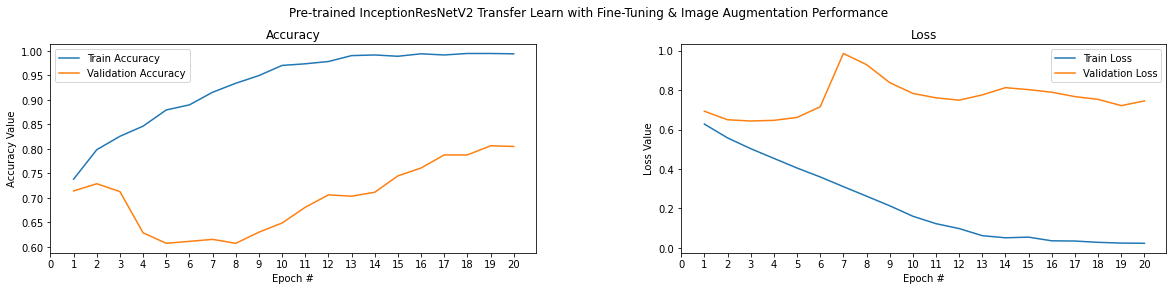

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained InceptionResNetV2 Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
model.save('/content/drive/MyDrive/deepfake-detection-model.h5')

True positive =  2910
False positive =  76
False negative =  74
True negative =  685




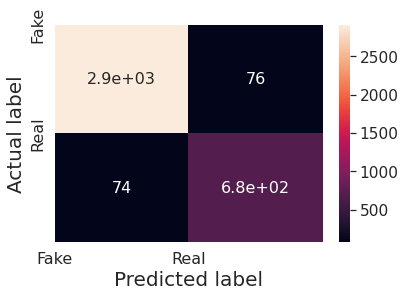

In [ ]:
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    
print_confusion_matrix(Y_val_org, np.argmax(model.predict(X), -1))

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_val_org , np.argmax(model.predict(X), -1))

0.9599465954606141

In [ ]:
import tensorflow as tf
import dlib
import cv2
import os
import numpy as np
from PIL import Image, ImageChops, ImageEnhance
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [ ]:
model = load_model('/content/drive/MyDrive/deepfake-detection-model.h5')

KeyboardInterrupt: ignored

In [ ]:
input_shape = (128, 128, 3)
pr_data = []
detector = dlib.get_frontal_face_detector()
cap = cv2.VideoCapture('test_videos/aassnaulhq.mp4')
frameRate = cap.get(5)
while cap.isOpened():
    frameId = cap.get(1)
    ret, frame = cap.read()
    if ret != True:
        break
    if frameId % ((int(frameRate)+1)*1) == 0:
        face_rects, scores, idx = detector.run(frame, 0)
        for i, d in enumerate(face_rects):
            x1 = d.left()
            y1 = d.top()
            x2 = d.right()
            y2 = d.bottom()
            crop_img = frame[y1:y2, x1:x2]
            data = img_to_array(cv2.resize(crop_img, (128, 128))).flatten() / 255.0
            data = data.reshape(-1, 128, 128, 3)
            print(np.argmax(model.predict(data), -1))